# Video analysis

I've simulated video data of a blob moving across a space of 128 x 128px (yay for powers of 2 this time). 

The blob is itself just an evaluation of a 2d gaussian kernel in the image space (which is a function of distance from center, a radius parameter, and a probability value for the center of the blob)

Each frame the effect of the blob is to sample from a Bernoulli distribution at every pixel, with probabilty given by the blob's values over the image space. In the end, we obtain a layer of what I'll call "claims" resulting from the movement of the blob, where each pixel in the image has values `{0, 1, ..., n_frames}`. Intuitively, more claims are generated closer to the center of the blob as it moves across the space.

In [50]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import glob
from tqdm.notebook import tqdm

import matplotlib.pylab
matplotlib.pylab.rcParams['figure.dpi'] = 200

In [150]:
VIDEO_DIR = 'simvid'

def sort_folders(folders, split_idx):
    idx = [int(x.split("_")[split_idx]) for x in folders]
    folders = [x for _, x in sorted(zip(idx, folders))]
    idx.sort()
    return folders, idx


def sort_files(files, split_idx):
    files = [os.path.splitext(x)[0] for x in files]
    idx = [int(x.split("_")[split_idx]) for x in files]
    files = [x for _, x in sorted(zip(idx, files))]
    idx.sort()
    return files, idx

video_dirs, video_idx = sort_folders(os.listdir(VIDEO_DIR), 1)


In [166]:
file_df = pd.DataFrame({
    "video_no": video_idx,
    "video_dirs": video_dirs,
    "train": random.choices([0, 1], weights = [0.2, 0.8], k=len(video_sequence))
})

file_df.head()

,video_no,video_dirs,train
0,0,blob_0_direction141.5_speed2.6_x53.0_y32.0_rad...,1
1,1,blob_1_direction-154.0_speed3.3_x89.0_y82.0_ra...,1
2,2,blob_2_direction-196.7_speed0.5_x74.0_y55.0_ra...,1
3,3,blob_3_direction36.9_speed0.7_x111.0_y121.0_ra...,1
4,4,blob_4_direction158.0_speed1.6_x0.0_y32.0_radi...,1


In [170]:
class CustomVideoDataset(Dataset):
    def __init__(self, df, parent_dir, transform_img):
        self.parent_dir = parent_dir
        self.videos = df.video_dirs.tolist()
        self.transform_img = transform_img
    def __len__(self):
        return len(self.videos)
    def __getitem__(self, idx):
        # Get frames from video set
        video_dir = os.path.join(self.parent_dir, self.videos[idx])        
        # Get blob files
        blob_frame_files = glob.glob("blob*", root_dir=video_dir)        
        blob_frame_files, blob_frame_idx = sort_files(blob_frame_files, 2)        
        blob_frame_files = [os.path.join(video_dir, x + '.png') for x in blob_frame_files]        
        blob_frame_images = [self.transform_img(Image.open(x)) for x in blob_frame_files]
        # Get claims data files
        claims_data_files = glob.glob("claims_data_*.png", root_dir=video_dir)
        claims_data_files, claims_data_idx = sort_files(claims_data_files, 2)
        claims_data_files = [os.path.join(video_dir, x + '.png') for x in claims_data_files]
        claims_data_images = [self.transform_img(Image.open(x)) for x in claims_data_files]        
        return blob_frame_images, claims_data_images
        
        

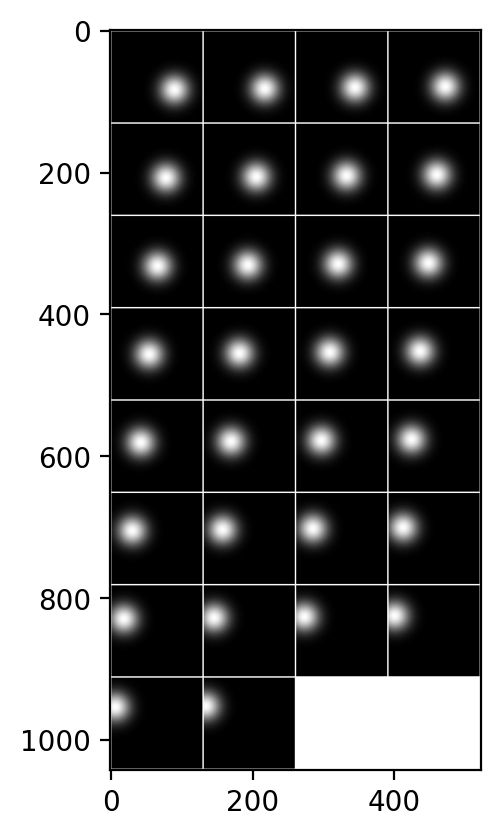

In [179]:
transform_img = transforms.Compose(
    [
        transforms.Grayscale(1),
        transforms.ToTensor()
    ]
)

traindata = CustomVideoDataset(
    file_df.query("train == 1"), VIDEO_DIR, transform_img
)
testdata = CustomVideoDataset(
    file_df.query("train == 0"), VIDEO_DIR, transform_img
)

train_dataloader = DataLoader(traindata, batch_size=12, shuffle=True)
test_dataloader  = DataLoader(testdata,  batch_size= 1, shuffle=True)

blob, claims = traindata.__getitem__(1)
plt.imshow(torchvision.utils.make_grid(blob, nrow=4, padding=2, pad_value=1, normalize=True).permute(1,2,0).detach().numpy())
plt.show()

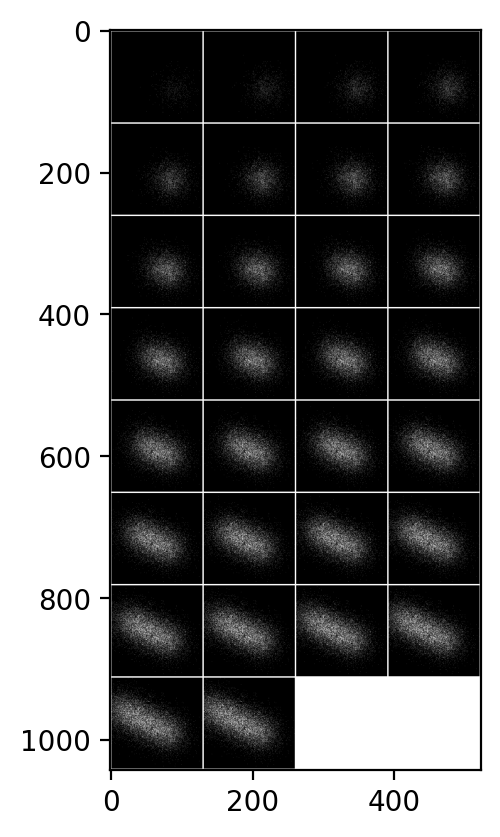

In [177]:
plt.imshow(torchvision.utils.make_grid(claims, nrow=4, padding=2, pad_value=1, normalize=True).permute(1,2,0).detach().numpy())
plt.show()

In [ ]:
torch.cat(blob